### Note
Perhaps it is best to link a google drive storage to this notebook. Downloading the model weights is time consuming and I'm afraid we may hit the colab disk threshold.

In [ ]:
!git clone https://github.com/halixness/point-e
%cd point-e/

In [ ]:
!pip install -e .
!pip install diffusers transformers accelerate

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# GLIDE 3B has been used // StableDiffusion 2 trained on LAION-5B
pipe = StableDiffusionPipeline.from_pretrained(
    #"CompVis/stable-diffusion-v1-4",
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
).to(device)

# Low GPU ram mode (but slower) 
pipe.enable_attention_slicing()

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "roses in a pot"
prompt_details = ", solid white background, full body centered camera view, blender render, high resolution, standard light, no reflections"
generated_image = pipe(prompt + prompt_details).images[0]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

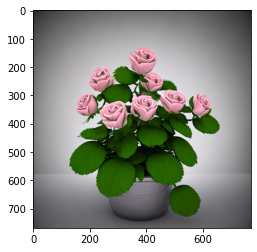

In [ ]:
plt.imshow(generated_image)

In [ ]:
PILtoTensor = transforms.ToTensor()
#generated_image = PILtoTensor(generated_image)

del pipe

In [ ]:
torch.cuda.empty_cache()

In [ ]:
base_name = 'base1B' # base40M, use base300M or base1B for better results
n_points = 1024
final_n_points = 4096
MODEL_CONFIGS[base_name]["n_ctx"] = n_points
MODEL_CONFIGS["upsample"]["n_ctx"] = final_n_points - n_points

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[n_points, final_n_points - n_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[generated_image]))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
samples.shape

torch.Size([1, 6, 4096])

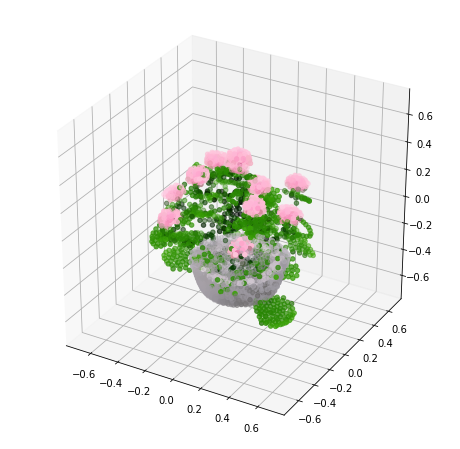

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

### pointcloud-to-mesh

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [ ]:
# Signed distance field model
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [ ]:
import skimage.measure
skimage.measure.label

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=90, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/178 [00:00<?, ?it/s]

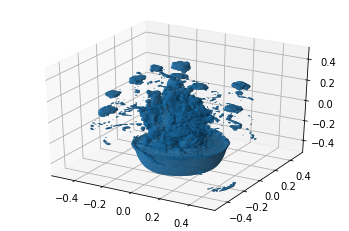

In [ ]:
# Write the mesh to a PLY file to import into some other program.
# with open('mesh.ply', 'wb') as f:
#    mesh.write_ply(f)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:,1], triangles=mesh.faces, Z=mesh.verts[:,2]) 
plt.show()